In [24]:

import pickle
import pandas as pd

# 构造文件名
filename = f"J0821-4221_0_RVM_fit_dynesty.pickle"

# 从 pickle 文件加载数据
data = pickle.load(open(filename, "rb"))


# 假设 data 是一个对象，里面有一个属性 samples
samples = data.samples  
print(samples.shape)
print(dir(data))



(270621, 4)
['_ALLOWED', '__class__', '__contains__', '__copy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_dynamic', '_initialized', '_keys', 'asdict', 'blob', 'copy', 'eff', 'importance_weights', 'information', 'isdynamic', 'items', 'keys', 'logl', 'logvol', 'logwt', 'logz', 'logzerr', 'ncall', 'niter', 'nlive', 'samples', 'samples_equal', 'samples_id', 'samples_it', 'samples_u', 'summary']


In [25]:
import numpy as np
import pandas as pd
import pickle

# 加载 pickle
filename = f"J0821-4221_0_RVM_fit_dynesty.pickle"
data = pickle.load(open(filename, "rb"))

# 样本和 log 权重
samples = data.samples      # shape (270621, 4)
logwt = data.logwt          # 对数权重

# 转换为线性权重并归一化
weights = np.exp(logwt - np.max(logwt))   # 避免溢出
weights /= np.sum(weights)                # 归一化

# 创建 DataFrame
df = pd.DataFrame(samples, columns=['alpha', 'beta', 'psi0', 'phi0'])
df['weight'] = weights

print(df.head())
print(df.describe())



        alpha       beta        psi0        phi0  weight
0   96.058575 -17.013258  142.004720  146.633093     0.0
1   74.404914  -9.061826   71.293280  143.804295     0.0
2   79.712098  15.453312  115.461538  149.156103     0.0
3  101.240586  21.856449   73.090765  149.841811     0.0
4   53.135587  88.751003  122.152172  148.405414     0.0
               alpha           beta           psi0           phi0  \
count  270621.000000  270621.000000  270621.000000  270621.000000   
mean       87.699359      -1.333398       6.308074       8.868575   
std        33.986709      29.546238      48.358843      29.579714   
min         0.005195     -89.998772    -149.992375    -149.954568   
25%        68.647130       1.250156       7.384747       7.910414   
50%        87.272251       2.197161       8.187071       9.910973   
75%       105.463403       2.318184       8.520655      14.732473   
max       179.997926      89.999417     149.999915     149.953240   

             weight  
count  2.70621

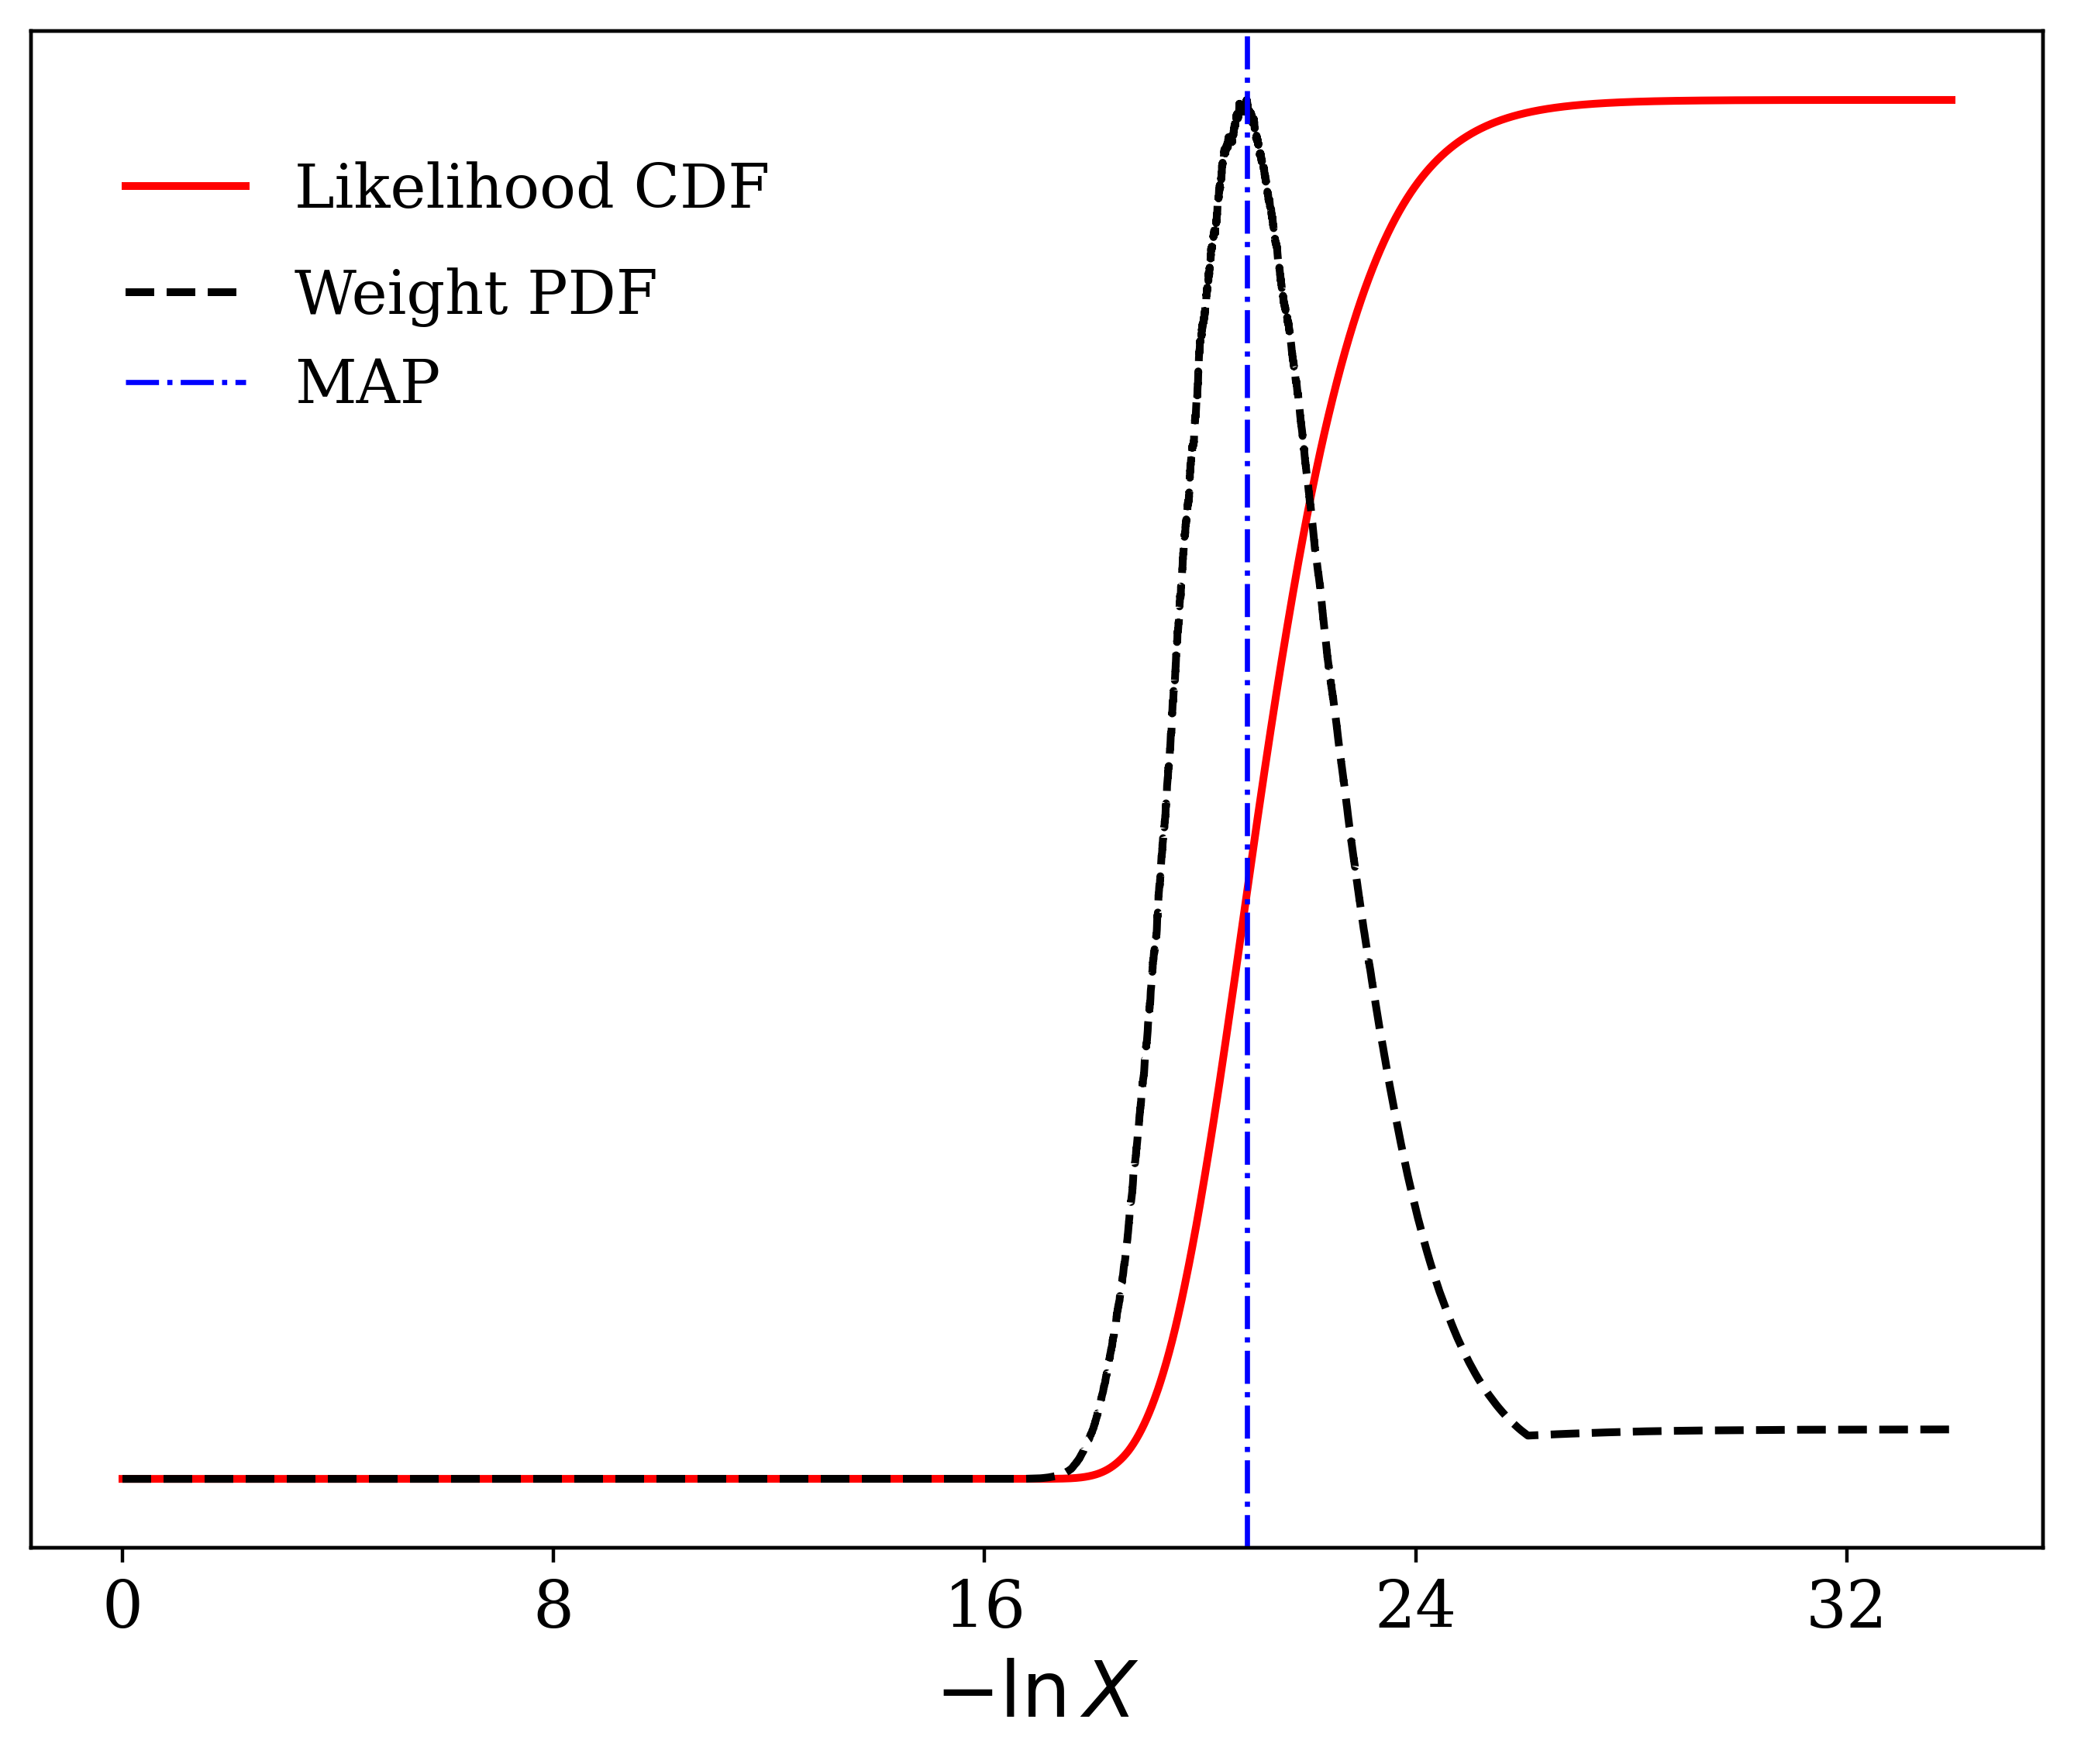

In [25]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# === 载入数据 ===
filename = "J0821-4221_0_RVM_fit_dynesty.pickle"
data = pickle.load(open(filename, "rb"))

# 提取必要数据
logl = np.array(data.logl)
logvol = np.array(data.logvol)
logwt = np.array(data.logwt)

# 横坐标：-ln X
x = -logvol

# 权重（线性 + 归一化）
weights = np.exp(logwt - np.max(logwt))
weights /= np.sum(weights)

# 按 -lnX 排序
sort_idx = np.argsort(x)
x_sorted = x[sort_idx]
logl_sorted = logl[sort_idx]
w_sorted = weights[sort_idx]

# 累积概率 (likelihood 曲线)
cdf = np.cumsum(w_sorted)
cdf /= cdf[-1]

# 权重 PDF（归一化）
pdf = w_sorted / np.max(w_sorted)

# --- 最大似然点 (ML) ---
ml_idx = np.argmax(logl_sorted)
ml_x = x_sorted[ml_idx]

# --- 最大后验点 (MAP) ---
map_idx = np.argmax(pdf)
map_x = x_sorted[map_idx]

# --- 3σ (99.7%) 置信区间 ---
cdf_pdf = np.cumsum(w_sorted)
cdf_pdf /= cdf_pdf[-1]
low_idx = np.where(cdf_pdf >= 0.0015)[0][0]
high_idx = np.where(cdf_pdf >= 0.9985)[0][0]
low_x, high_x = x_sorted[low_idx], x_sorted[high_idx]

# ========== 绘图（学术风格） ==========
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 17  # 默认字体大小
})

fig, ax1 = plt.subplots(figsize=(7, 6), dpi=400)

# --- 蓝色曲线改为黑色实线 (Likelihood) ---
line1, = ax1.plot(
    x_sorted, cdf,
    color="r", lw=1.8, ls="-",
    label="Likelihood CDF"
)
ax1.set_ylabel("Likelihood (normalized)", color="black")
ax1.tick_params(axis="y", labelcolor="black", labelsize=18)  # y轴刻度标签大小
ax1.xaxis.set_major_locator(MaxNLocator(nbins=6))  # x轴主刻度数量

# --- 红色曲线改为黑色虚线 (Weight PDF) ---
ax2 = ax1.twinx()
line2, = ax2.plot(
    x_sorted, pdf,
    color="black", lw=1.8, ls="--",
    label="Weight PDF"
)
ax2.set_ylabel("Importance Weight PDF", color="black")
ax2.tick_params(axis="y", labelcolor="black", labelsize=18)  # y轴刻度标签大小
ax2.yaxis.set_major_locator(MaxNLocator(nbins=4))  # y轴主刻度数量

# --- 标记 MAP 竖线 ---
ax2.axvline(
    map_x, color="blue",
    ls="dashdot", lw=1.2,
    label="MAP"
)

# --- 3σ 阴影 ---
# ax2.fill_between(
#     x_sorted, 0, pdf,
#     where=((x_sorted >= low_x) & (x_sorted <= high_x)),
#     color="lightgray", alpha=0.6,
#     label="3σ interval"
# )

# 横坐标

ax1.set_xlabel(r"$-\ln X$", fontsize=18)
ax1.xaxis.set_major_locator(MaxNLocator(nbins=6))  # x轴主刻度数量
ax1.yaxis.set_major_locator(MaxNLocator(nbins=4))  # x轴主刻度数量
ax1.tick_params(axis="x", labelsize=15)  # x轴刻度标签大小
ax1.yaxis.set_visible(False)  # 完全隐藏纵坐标

# === 图例放在图内左上角，并设置字体大小和列数 ===
ax1.legend(
    loc="upper left", bbox_to_anchor=(0.02, 0.95),
    frameon=False, fontsize=14, ncol=1
)
ax2.legend(
    loc="upper left", bbox_to_anchor=(0.02, 0.88),
    frameon=False, fontsize=14, ncol=1
)
ax2.yaxis.set_visible(False)  # 完全隐藏纵坐标

plt.tight_layout()
plt.savefig("nestedsamoling.pdf")
plt.show()


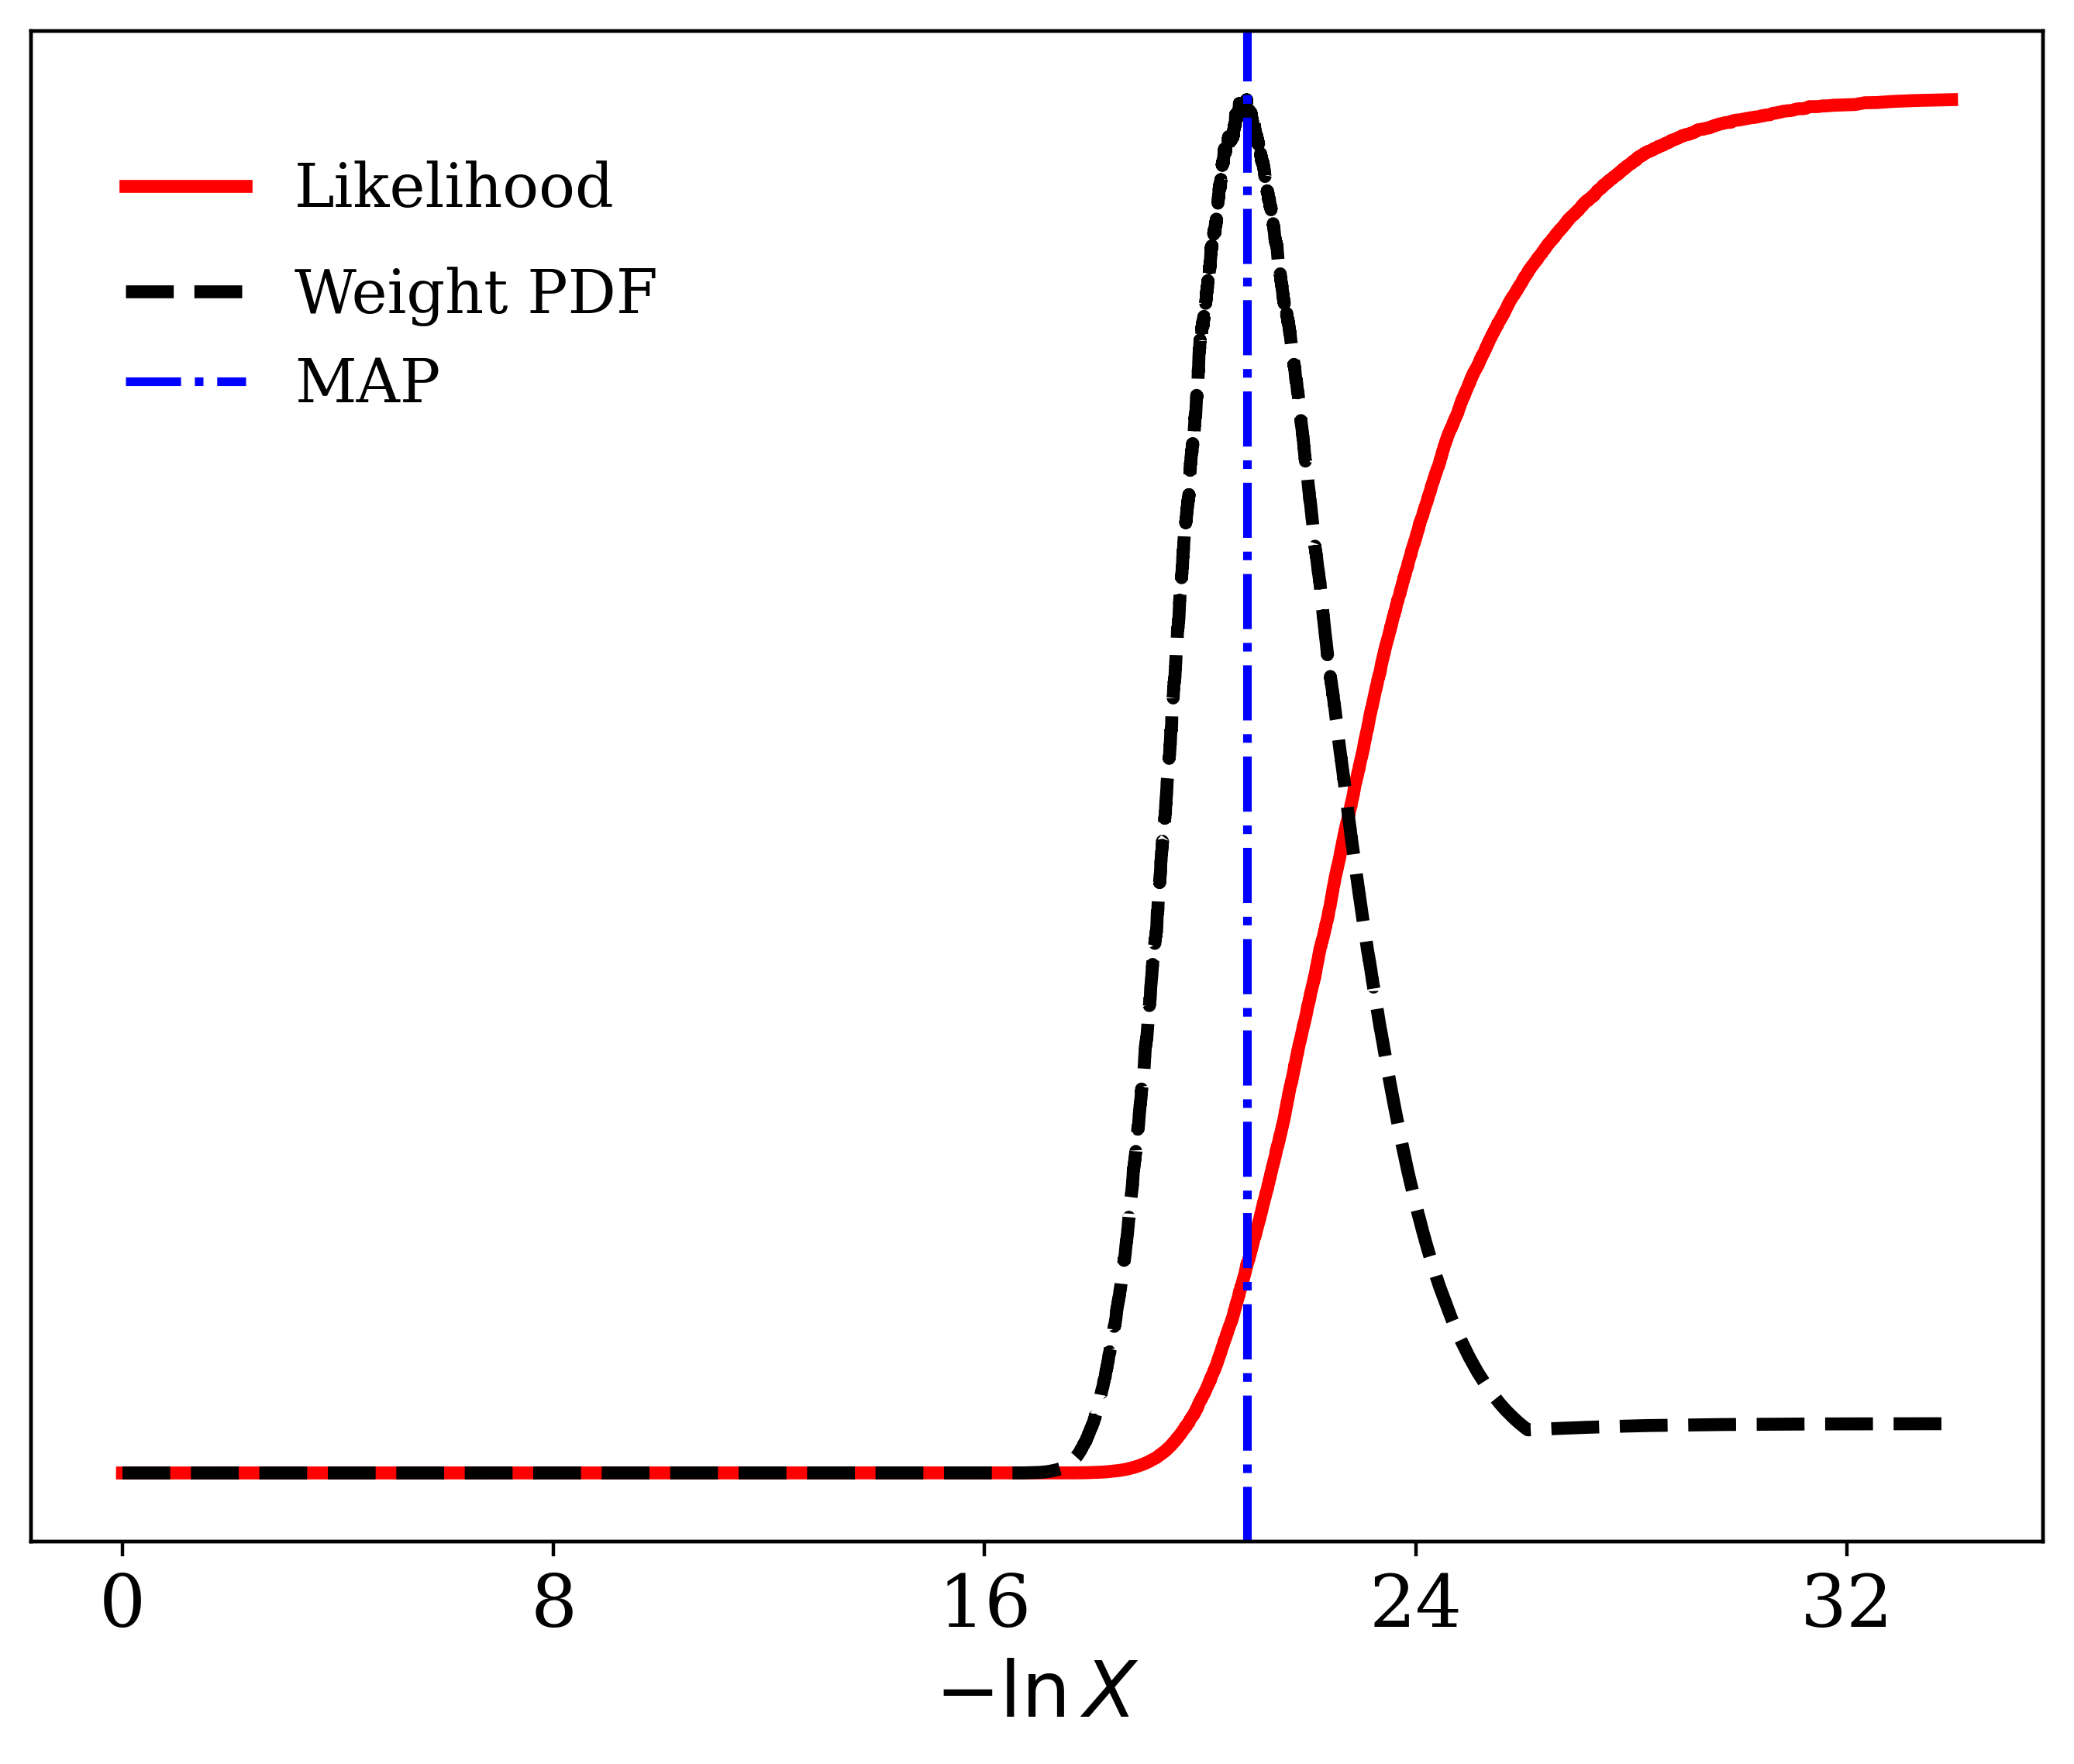

In [28]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# === 载入数据 ===
filename = "J0821-4221_0_RVM_fit_dynesty.pickle"
data = pickle.load(open(filename, "rb"))

# 提取必要数据
logl = np.array(data.logl)
logvol = np.array(data.logvol)
logwt = np.array(data.logwt)

# 横坐标：-ln X
x = -logvol

# 权重（线性 + 归一化）
weights = np.exp(logwt - np.max(logwt))
weights /= np.sum(weights)

# 排序（按 -lnX）
sort_idx = np.argsort(x)
x_sorted = x[sort_idx]
logl_sorted = logl[sort_idx]
w_sorted = weights[sort_idx]

# === 直接使用 log-likelihood，归一化后绘图 ===
lik = np.exp(logl_sorted - np.max(logl_sorted))  # likelihood in [0,1]

# 权重 PDF（归一化）
pdf = w_sorted / np.max(w_sorted)

# 最大似然点 (ML)
ml_idx = np.argmax(lik)
ml_x = x_sorted[ml_idx]

# 最大后验点 (MAP)
map_idx = np.argmax(pdf)
map_x = x_sorted[map_idx]

# ========== 绘图 ==========
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 17
})

fig, ax1 = plt.subplots(figsize=(7, 6), dpi=400)

# --- Likelihood 曲线（红色实线） ---
line1, = ax1.plot(
    x_sorted, lik,
    color="red", lw=3, ls="-",
    label="Likelihood"
)
ax1.set_ylabel("Likelihood (normalized)", color="black")
ax1.tick_params(axis="y", labelcolor="black", labelsize=18)
ax1.xaxis.set_major_locator(MaxNLocator(nbins=6))

# --- 权重 PDF（黑色虚线） ---
ax2 = ax1.twinx()
line2, = ax2.plot(
    x_sorted, pdf,
    color="black", lw=3, ls="--",
    label="Weight PDF"
)
ax2.set_ylabel("Importance Weight PDF", color="black")
ax2.tick_params(axis="y", labelcolor="black", labelsize=18)
ax2.yaxis.set_major_locator(MaxNLocator(nbins=4))

# MAP 竖线
ax2.axvline(
    map_x, color="blue",
    ls="dashdot", lw=2,
    label="MAP"
)

# 隐藏双Y轴
ax1.yaxis.set_visible(False)
ax2.yaxis.set_visible(False)

ax1.set_xlabel(r"$-\ln X$", fontsize=18)

# === 图例 ===
ax1.legend(
    loc="upper left", bbox_to_anchor=(0.02, 0.95),
    frameon=False, fontsize=14
)
ax2.legend(
    loc="upper left", bbox_to_anchor=(0.02, 0.88),
    frameon=False, fontsize=14
)

plt.tight_layout()
plt.savefig("nestedsampling.pdf")
plt.show()
